# Final Project Forecasting

Course: Predictive Modelling Analytics

Group Member:
- xxx
- xxx
- xxx


## Setup
### Initialize Global Variables

In [79]:
WINDOW_SIZE = 12 # 12 months (1 year)
FORECAST_WINDOW = 12 # 1 years
ARRIVAL = 'Kedatangan_Internasional'

### Import Libraries, Dependencides and Dataset

In [80]:
# Importing the libraries
# %pip install pmdarima tensorflow

import pandas as pd
from pandas import read_csv
from pandas import to_datetime

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# import warnings
# warnings.filterwarnings('ignore')

# Importing the dataset
data = read_csv("Dataset/Data_FP_PAP-C.csv")
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,01/01/2017
1,2017,2,8775,2,02/01/2017
2,2017,3,11305,3,03/01/2017
3,2017,4,13204,4,04/01/2017
4,2017,5,11792,5,05/01/2017


## Preprocessing

In [81]:
#Checking for missing values
data.isnull().sum()

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [82]:
# Check NaN values
data.isnull().sum() 

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [83]:
curr = pd.to_datetime(data.iloc[-1]['Tanggal']).strftime('%m/%d/%Y').split('/')
index = []
for i in range(12):
    m = int(curr[0])
    y = int(curr[2])
    if m < 12:
        curr[0] = str(m+1)
    else:
        curr[2] = str(y+1)
        curr[0] = str(1)
    idx = "/".join(curr)
    index.append(idx)
index_forecast = to_datetime(pd.Series(index))
index_forecast

0    2024-11-01
1    2024-12-01
2    2025-01-01
3    2025-02-01
4    2025-03-01
5    2025-04-01
6    2025-05-01
7    2025-06-01
8    2025-07-01
9    2025-08-01
10   2025-09-01
11   2025-10-01
dtype: datetime64[ns]

In [84]:
data['Tanggal'] = to_datetime(data['Tanggal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tahun                     94 non-null     int64         
 1   Bulan                     94 non-null     int64         
 2   Kedatangan_Internasional  94 non-null     int64         
 3   Periode                   94 non-null     int64         
 4   Tanggal                   94 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.8 KB


In [85]:
scaler = MinMaxScaler()
data[ARRIVAL] = scaler.fit_transform(data[ARRIVAL].values.reshape(-1, 1))
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,0.671960,1,2017-01-01
1,2017,2,0.627682,2,2017-02-01
2,2017,3,0.808655,3,2017-03-01
3,2017,4,0.944492,4,2017-04-01
4,2017,5,0.843491,5,2017-05-01


## Exploratory Data Analysis (EDA)

### Visualization

In [86]:
def visualize(data, var=[], label=''):
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Kedatangan Bandara Internasional Lombok {label}', fontsize=20)

    for v in var:
        plt.plot(data['Tanggal'], data[v], label=v)
    
    plt.xlim(data['Tanggal'].min(), data['Tanggal'].max())
    plt.xlabel('Date', fontsize=15)

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))

    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    ax.get_yaxis().get_major_formatter().set_scientific(False)

    plt.legend()  
    plt.show()

In [87]:
def compare_pred_actual(results, title):
    """
    Compare predictions and actual values from different scenarios or models.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    # Plot predictions and actuals for ARRIVAL
    for scenario, result in results.items():
        ax.plot(result['Predictions'], label=f'{scenario} Predictions', linestyle='--')
        ax.plot(result['Actuals'], label=f'{scenario} Actuals', alpha=0.7)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.legend(loc='best')
    plt.show()

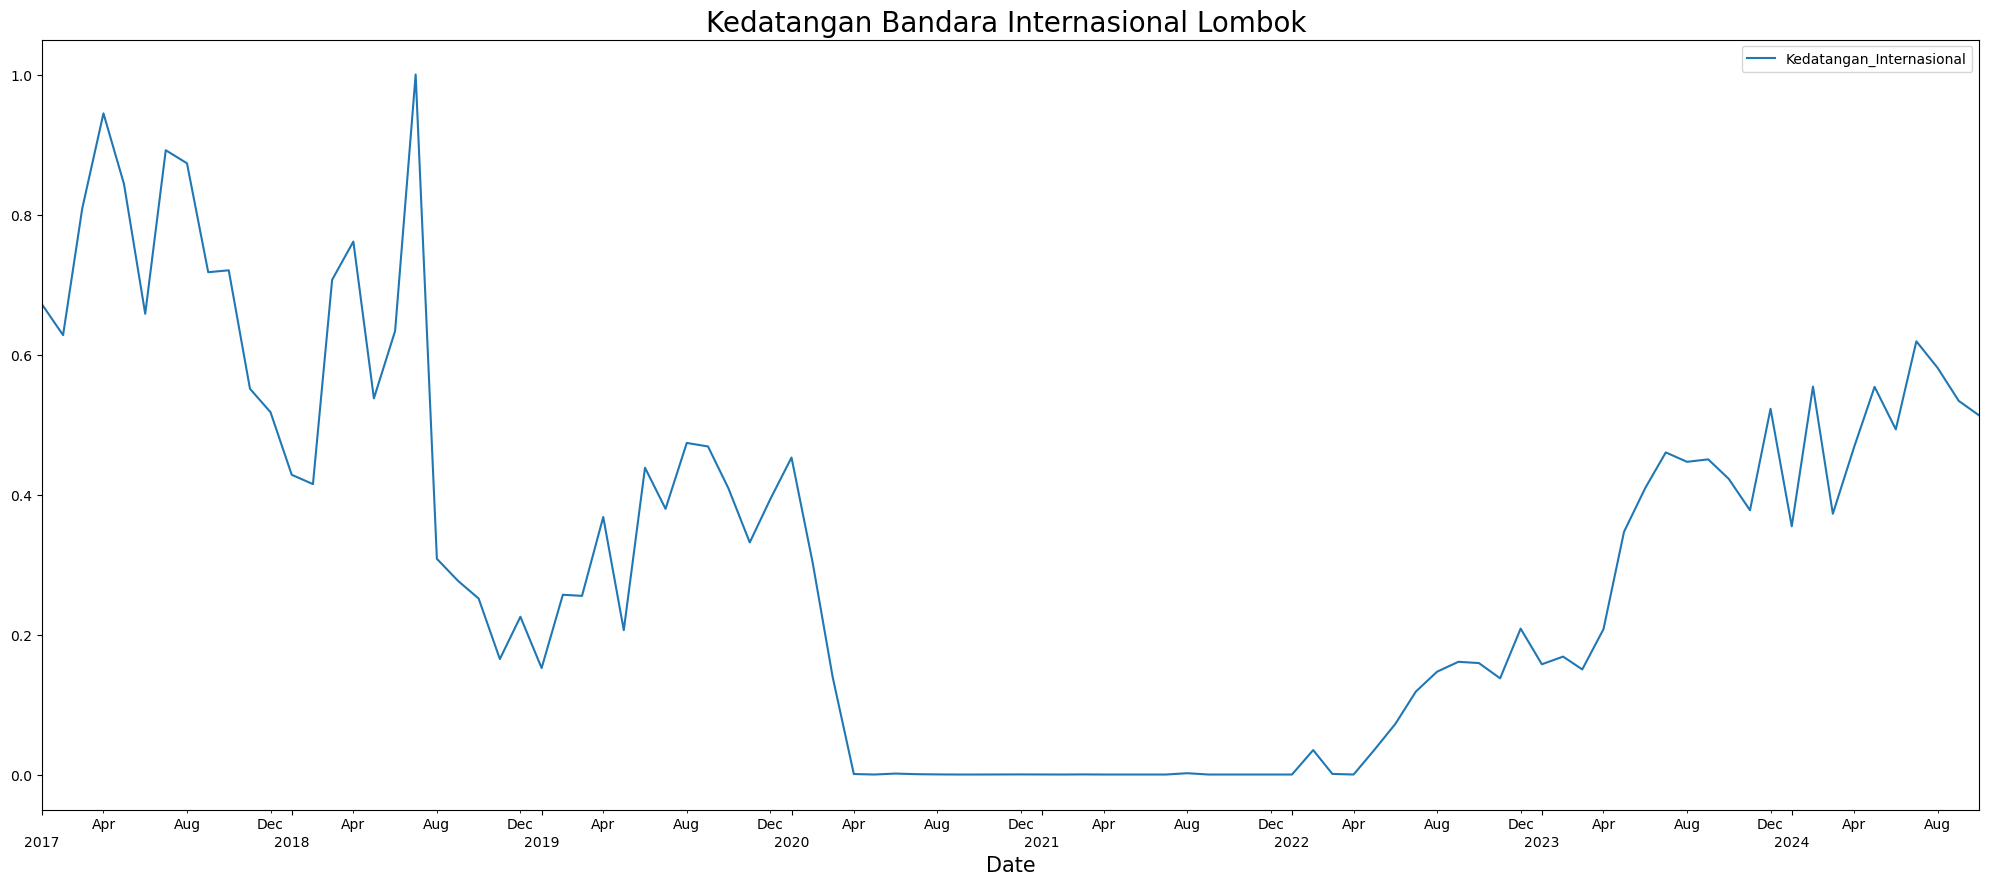

In [88]:
visualize(data, [ARRIVAL])

## Modeling
### Data Windows

In [89]:
def dataframe_to_windowed_data(df, window_size):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]

    y.append(label)
  return np.array(x), np.array(y)

### Building Models
#### Prophet


#### SARIMA

In [91]:
# Augmented Dickey-Fuller Test
def adf_test(data):
    result = adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(data[ARRIVAL])

ADF Statistic: -1.8235632254380565
p-value: 0.36882753783642386
Critical Values:
	1%: -3.503514579651927
	5%: -2.893507960466837
	10%: -2.583823615311909


In [138]:
# Make Sarima model
def make_sarima_model(data, window_size, forecast_window):
    # Split the data
    train_data = data[ARRIVAL].values
    train_data = train_data.reshape(-1, 1)
    train_data, test_data = train_test_split(train_data, test_size=0.2, shuffle=False)
    train_data = train_data.reshape(-1)
    test_data = test_data.reshape(-1)

    # Fit the model
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=forecast_window)

    # Calculate the error
    mae = mean_absolute_error(test_data, forecast)
    mape = mean_absolute_percentage_error(test_data, forecast)
    mse = mean_squared_error(test_data, forecast)
    r2 = r2_score(test_data, forecast)

    return forecast, mae, mape, mse, r2

#### LSTM

In [107]:
def create_LSTM() -> Sequential:
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=True))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(64, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(8, activation='relu'))
    model_LSTM.add(Dense(1, activation='linear'))
    model_LSTM.compile(optimizer='adam', loss='mse')
    return model_LSTM

def train_LSTM(train_ratio=0.8) -> dict:
    train_res = {}
    test_res = {}

    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    range_index_train = int(train_ratio * len(x))

    x_train, y_train = x[:range_index_train], y[:range_index_train]
    x_test, y_test = x[range_index_train:], y[range_index_train:]

    model_LSTM = create_LSTM()
    model_LSTM.fit(x_train, y_train, epochs=100, batch_size=2)

    train_predictions = model_LSTM.predict(x_train).flatten()
    train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train})
    train_res[ARRIVAL] = train_results

    predictions_LSTM = model_LSTM.predict(x_test).flatten()
    test_results = pd.DataFrame(data={'Predictions': predictions_LSTM, 'Actuals': y_test})
    test_res[ARRIVAL] = test_results

    return train_res, test_res

def forecast_LSTM(forecast_window):
    results = {}

    model = create_LSTM()
    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    model.fit(x, y, epochs=100, batch_size=2)
    
    forecast = []
    current_input = y[-WINDOW_SIZE:].reshape((1, WINDOW_SIZE, 1))
    
    for _ in range(forecast_window):
        next_pred = model.predict(current_input)[0, 0]
        forecast.append(next_pred)
        current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)
    
    forecast = pd.Series(forecast, index=index_forecast)
    results[ARRIVAL] = forecast
    
    return results


#### HYBRID (ARIMA-LSTM)

In [108]:
def train_hybrid_ARIMA_LSTM(train_ratio=0.8, window_size=12, epochs=100, batch_size=2):
    """
    Train Hybrid ARIMA-LSTM model:
    1. ARIMA captures linear patterns.
    2. LSTM captures non-linear residual patterns.
    """
    # Step 1: Train ARIMA
    arima_results = train_ARIMA(train_ratio)
    arima_predictions = arima_results[train_ratio]['Predictions']
    actuals = arima_results[train_ratio]['Actuals']

    # Residuals for LSTM
    residuals = actuals - arima_predictions

    # Step 2: Train LSTM on residuals
    # Prepare windowed data for residuals
    scaler = MinMaxScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
    x, y = dataframe_to_windowed_data(residuals_scaled, window_size)

    # Train-test split for LSTM
    split_idx = int(train_ratio * len(x))
    x_train, y_train = x[:split_idx], y[:split_idx]
    x_test, y_test = x[split_idx:], y[split_idx:]

    # Train LSTM model
    lstm_model = create_LSTM()
    lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # LSTM predictions (inverse scaling)
    lstm_train_predictions = scaler.inverse_transform(lstm_model.predict(x_train).flatten().reshape(-1, 1))
    lstm_test_predictions = scaler.inverse_transform(lstm_model.predict(x_test).flatten().reshape(-1, 1))

    # Combine ARIMA and LSTM predictions
    train_hybrid_predictions = arima_predictions.iloc[:len(lstm_train_predictions)] + lstm_train_predictions.flatten()
    test_hybrid_predictions = arima_predictions.iloc[len(lstm_train_predictions):] + lstm_test_predictions.flatten()

    # Combine actuals
    train_actuals = actuals.iloc[:len(train_hybrid_predictions)]
    test_actuals = actuals.iloc[len(train_hybrid_predictions):]

    # Return results
    return {
        "ARIMA": arima_predictions,
        "LSTM_Residuals_Train": lstm_train_predictions,
        "LSTM_Residuals_Test": lstm_test_predictions,
        "Hybrid_Train": train_hybrid_predictions,
        "Hybrid_Test": test_hybrid_predictions,
        "Actuals_Train": train_actuals,
        "Actuals_Test": test_actuals
    }, lstm_model, scaler


## Training and Testing

1. 80% Train - 20% Test
2. 70% Train - 30 % Test
3. 60% Train - 40 % Test


## Evaluation


In [109]:
def evaluate_model(actual, predicted):
    """
    Evaluate the model using MSE, MAPE, MAE, and R² metrics.
    """
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Avoid division by zero
    r2 = r2_score(actual, predicted)
    return mse, mae, mape, r2

def train_and_evaluate_SARIMA(train_ratio, seasonal_period):
    """
    Train and evaluate the SARIMA model with a given train-test split ratio.
    """
    results = {}

    # Split the data into training and testing sets
    train, test = train_test_split(data, train_size=train_ratio, shuffle=False)

    # Create and fit the SARIMA model
    model_SARIMA = create_SARIMA(train[ARRIVAL], seasonal_period)

    # Generate predictions
    predictions_SARIMA = model_SARIMA.predict(n_periods=len(test))
    predictions_SARIMA = pd.Series(
        list(train[ARRIVAL]) + list(predictions_SARIMA),
        index=data['Tanggal']
    )

    # Prepare test series for evaluation
    pad = [None] * len(train[ARRIVAL])
    test_series = pd.Series(pad + list(test[ARRIVAL]), index=data['Tanggal'])

    # Evaluate the model
    mse, mae, mape, r2 = evaluate_model(test[ARRIVAL], predictions_SARIMA[len(train):])
    results[ARRIVAL] = {
        'Predictions': predictions_SARIMA,
        'Actuals': data[ARRIVAL],
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

    return results 

### Prophet

### SARIMA

ADF Statistic: -1.7558287087854554
p-value: 0.40260134952577176
Data is not stationary. Differencing will be applied.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-95.648, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-92.307, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-94.401, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-96.413, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-94.785, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-95.272, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-94.963, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.117 seconds
Metrics - Train Ratio: 0.8
MSE: 0.1020, MAE: 0.3039, MAPE: 64.80%, R²: -9.5687


/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


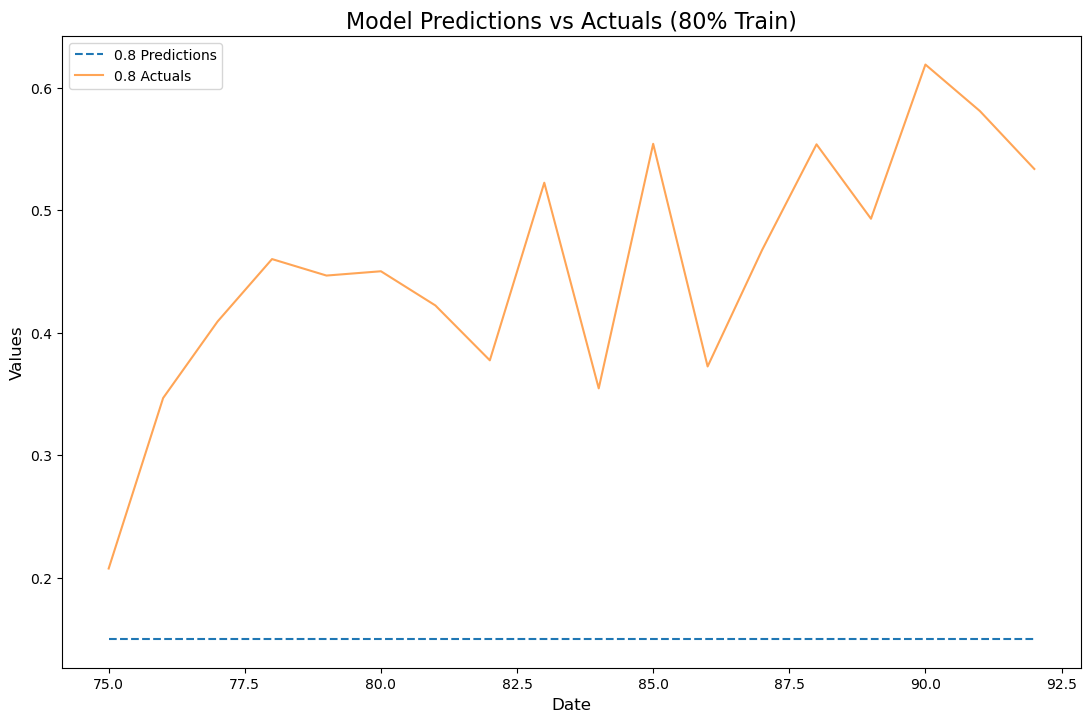

ARIMA Model Evaluation Metrics (80% Train):
MSE: 0.1019925847243229
MAE: 0.30387855666825625
MAPE: 64.80102636445164
R²: -9.568733444330666
ADF Statistic: -1.4281366973795062
p-value: 0.5687151959706066
Data is not stationary. Differencing will be applied.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-73.028, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-70.968, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-72.554, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-74.414, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-72.797, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-73.260, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-73.333, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.089 seconds
Metrics - Train Ratio: 0.7
MSE: 0.1241, MAE: 0.3099, MAPE: 85.72%, R²: -3.4172


/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


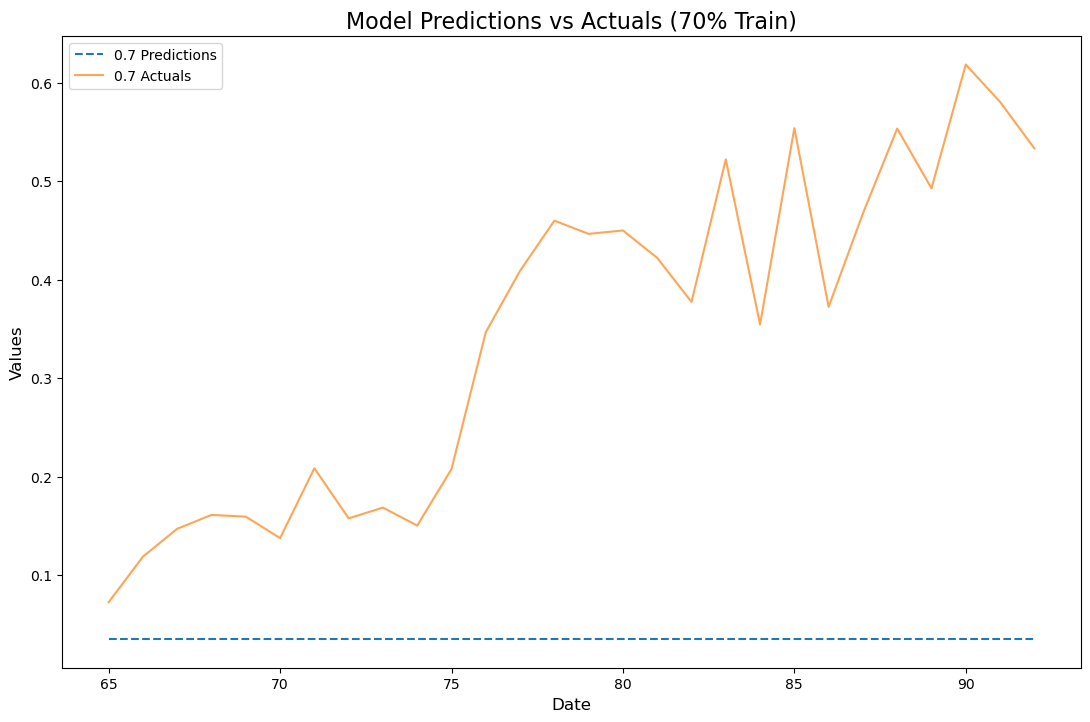

ARIMA Model Evaluation Metrics (80% Train):
MSE: 0.1019925847243229
MAE: 0.30387855666825625
MAPE: 64.80102636445164
R²: -9.568733444330666
ADF Statistic: -1.7933200065397252
p-value: 0.38378313200896474
Data is not stationary. Differencing will be applied.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-53.093, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-52.537, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-53.600, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-55.178, Time=0.01 sec


/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-53.506, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-53.901, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-54.173, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.085 seconds
Metrics - Train Ratio: 0.6
MSE: 0.1103, MAE: 0.2616, MAPE: inf%, R²: -1.6130


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


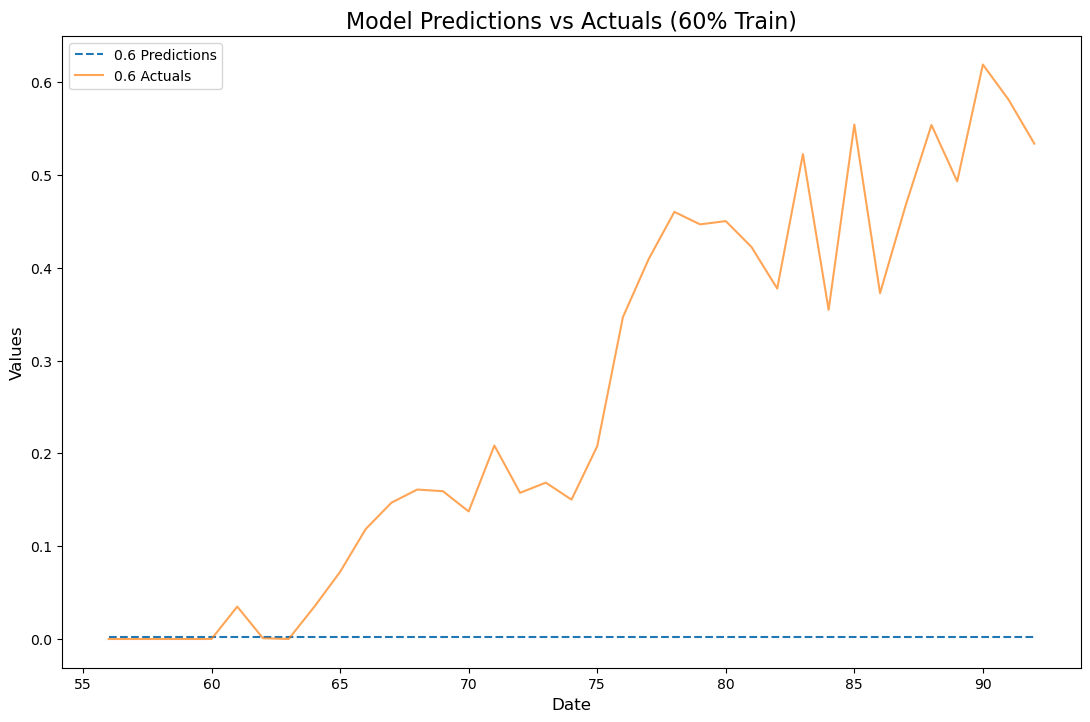

ARIMA Model Evaluation Metrics (80% Train):
MSE: 0.1019925847243229
MAE: 0.30387855666825625
MAPE: 64.80102636445164
R²: -9.568733444330666


In [139]:
# Scenario 1: 80% Train - 20% Test
results_80 = train_ARIMA(0.8)
compare_pred_actual(results_80, title="Model Predictions vs Actuals (80% Train)")

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(results_80[0.8]['Actuals'], results_80[0.8]['Predictions'])
print(f"ARIMA Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 2: 70% Train - 30% Test
results_70 = train_ARIMA(0.7)
compare_pred_actual(results_70, title="Model Predictions vs Actuals (70% Train)")

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(results_80[0.8]['Actuals'], results_80[0.8]['Predictions'])
print(f"ARIMA Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 3: 60% Train - 40% Test
results_60 = train_ARIMA(0.6)
compare_pred_actual(results_60, title="Model Predictions vs Actuals (60% Train)")\

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(results_80[0.8]['Actuals'], results_80[0.8]['Predictions'])
print(f"ARIMA Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

### LSTM

/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0669
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0278
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoc

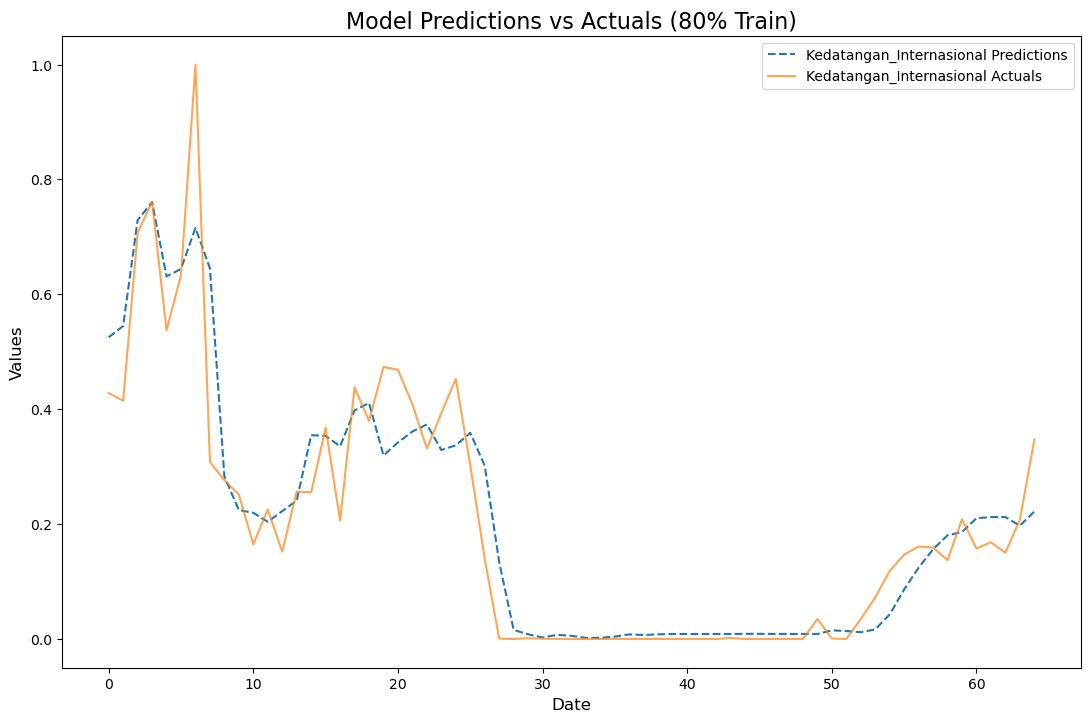

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0754  
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0853
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0620
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0865
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0678
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0559
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0659
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0523
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0629
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Epoch 16/100
2

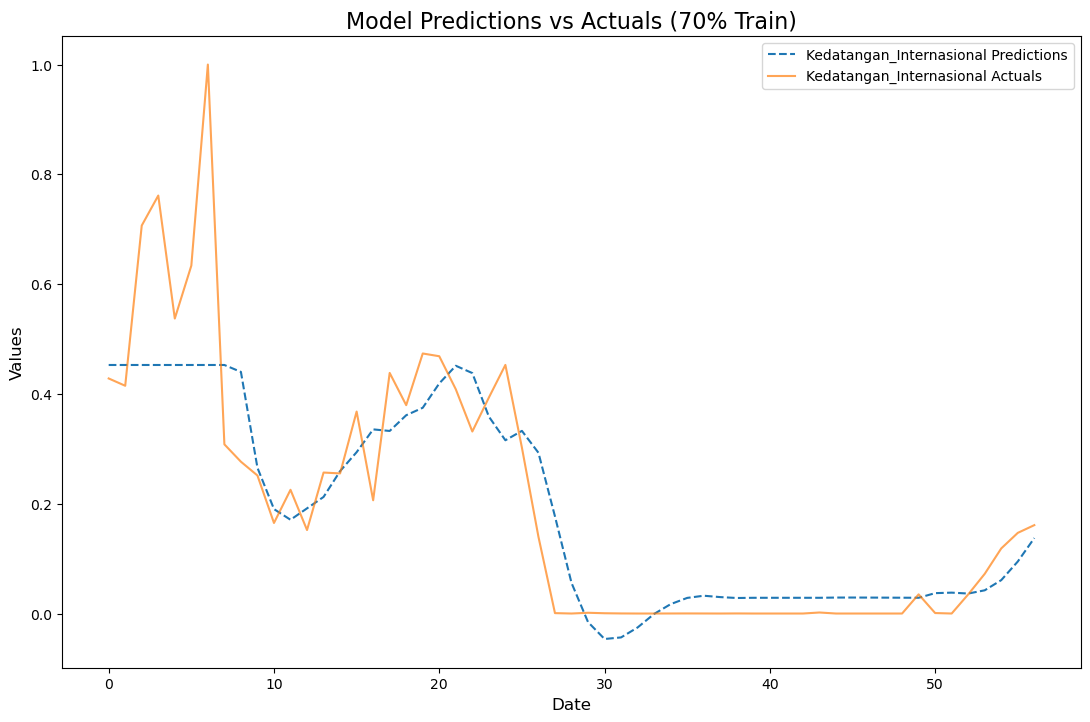

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0703  
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0349
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168    
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 16/1

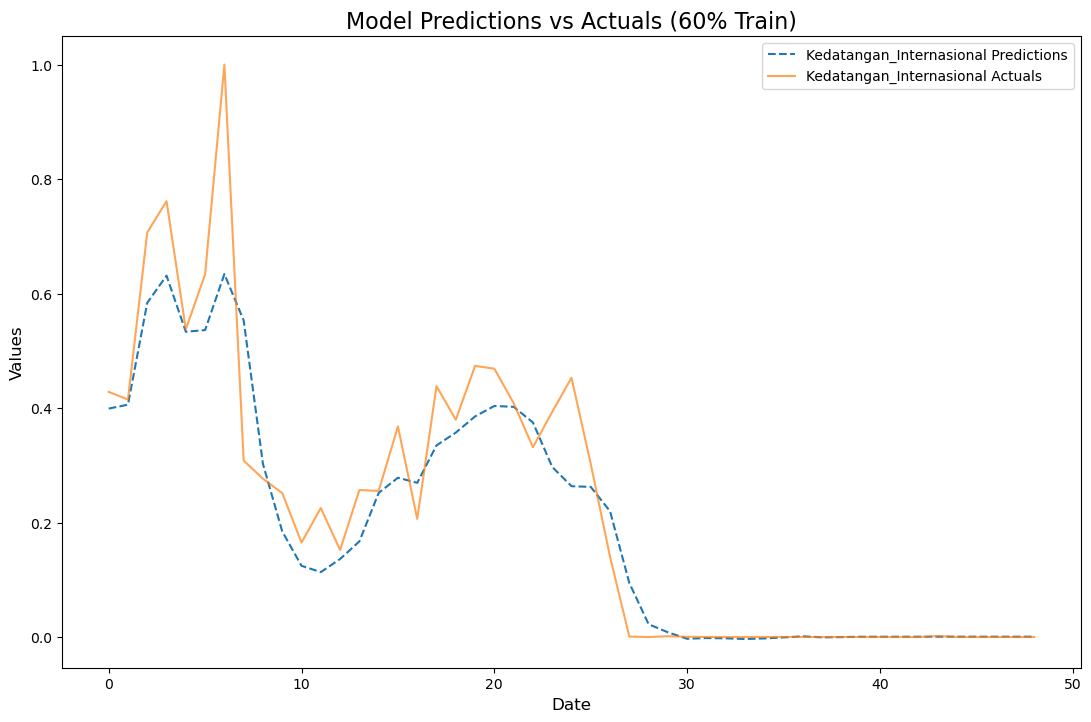

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935


In [111]:
LSTM_train_results_80, LSTM_test_results_80 = train_LSTM(0.8)
compare_pred_actual(LSTM_train_results_80, title="Model Predictions vs Actuals (80% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

LSTM_train_results_70, LSTM_test_results_70 = train_LSTM(0.7)
compare_pred_actual(LSTM_train_results_70, title="Model Predictions vs Actuals (70% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

LSTM_train_results_60, LSTM_test_results_60 = train_LSTM(0.6)
compare_pred_actual(LSTM_train_results_60, title="Model Predictions vs Actuals (60% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")



### HYBRID (SARIMA-LSTM)

In [112]:
# Initialize results dictionary
result = {}

# Train the ARIMA-LSTM Hybrid model
hybrid_results, lstm_model, scaler = train_hybrid_ARIMA_LSTM(
    train_ratio=0.8,  # Train-test split ratio
    window_size=12,  # Look-back window size for LSTM
    epochs=100,  # Number of epochs for LSTM
    batch_size=2  # Batch size for LSTM
)

# Combine results into a single dictionary
result['ARRIVAL'] = pd.DataFrame({
    'ARIMA': hybrid_results['ARIMA'],  # ARIMA predictions
    'LSTM_Train': pd.Series(hybrid_results['LSTM_Residuals_Train'].flatten(), index=hybrid_results['Actuals_Train'].index),
    'LSTM_Test': pd.Series(hybrid_results['LSTM_Residuals_Test'].flatten(), index=hybrid_results['Actuals_Test'].index),
    'Hybrid_Train': hybrid_results['Hybrid_Train'],  # Hybrid predictions on train data
    'Hybrid_Test': hybrid_results['Hybrid_Test'],  # Hybrid predictions on test data
    'Actuals_Train': hybrid_results['Actuals_Train'],  # Actual values (train)
    'Actuals_Test': hybrid_results['Actuals_Test']   # Actual values (test)
})

# Visualize and Compare Predictions
compare_pred_actual({'ARRIVAL': result['ARRIVAL']})


ADF Statistic: -1.7558287087854554
p-value: 0.40260134952577176
Data is not stationary. Differencing will be applied.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-95.648, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-92.307, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-94.401, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-96.413, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-94.785, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-95.272, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-94.963, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.099 seconds
Metrics - Train Ratio: 0.8
MSE: 0.1020, MAE: 0.3039, MAPE: 64.80%, R²: -9.5687


/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

## Implementation


### Combine Historical and Forecast Data

In [113]:
def combine_data(region, forecast, data):
    historical = data[['Tanggal', region]].copy()
    historical.columns = ['Tanggal', 'Historical']
    forecast.columns = ['Tanggal', 'Forecast']
    combined = pd.merge(historical, forecast, on='Tanggal', how='outer')
    return combined

In [129]:
# Make Comparsion Visualization Historical,Forecast
def visualize_forecast(region, forecast, data):
    combined = combine_data(region, forecast, data)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(combined['Tanggal'], combined['Historical'], label='Historical', color='blue')
    ax.plot(combined['Tanggal'], combined['Forecast'], label='Forecast', color='red')
    ax.set_title(f'{region} Forecast vs Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(region)
    ax.legend(loc='upper left')
    plt.show()

### Prophet

### SARIMA

In [115]:
forecasts = forecast_SARIMA(forecast_window)

# Combine historical and forecast data
historical_data = data[['Tanggal', ARRIVAL]].copy()
historical_data.columns = ['Tanggal', 'Historical']
forecast_data = pd.DataFrame({
    'Tanggal': index_forecast[:forecast_window],
    'Forecast': forecasts[ARRIVAL]
})

combined_data = pd.merge(historical_data, forecast_data, on='Tanggal', how='outer')
print(combined_data)


NameError: name 'forecast_SARIMA' is not defined

#### LSTM

In [124]:
LSTM_forecast = forecast_LSTM(FORECAST_WINDOW)

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0632  
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206   
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181
Epoch 15/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193
Epoch 16/10

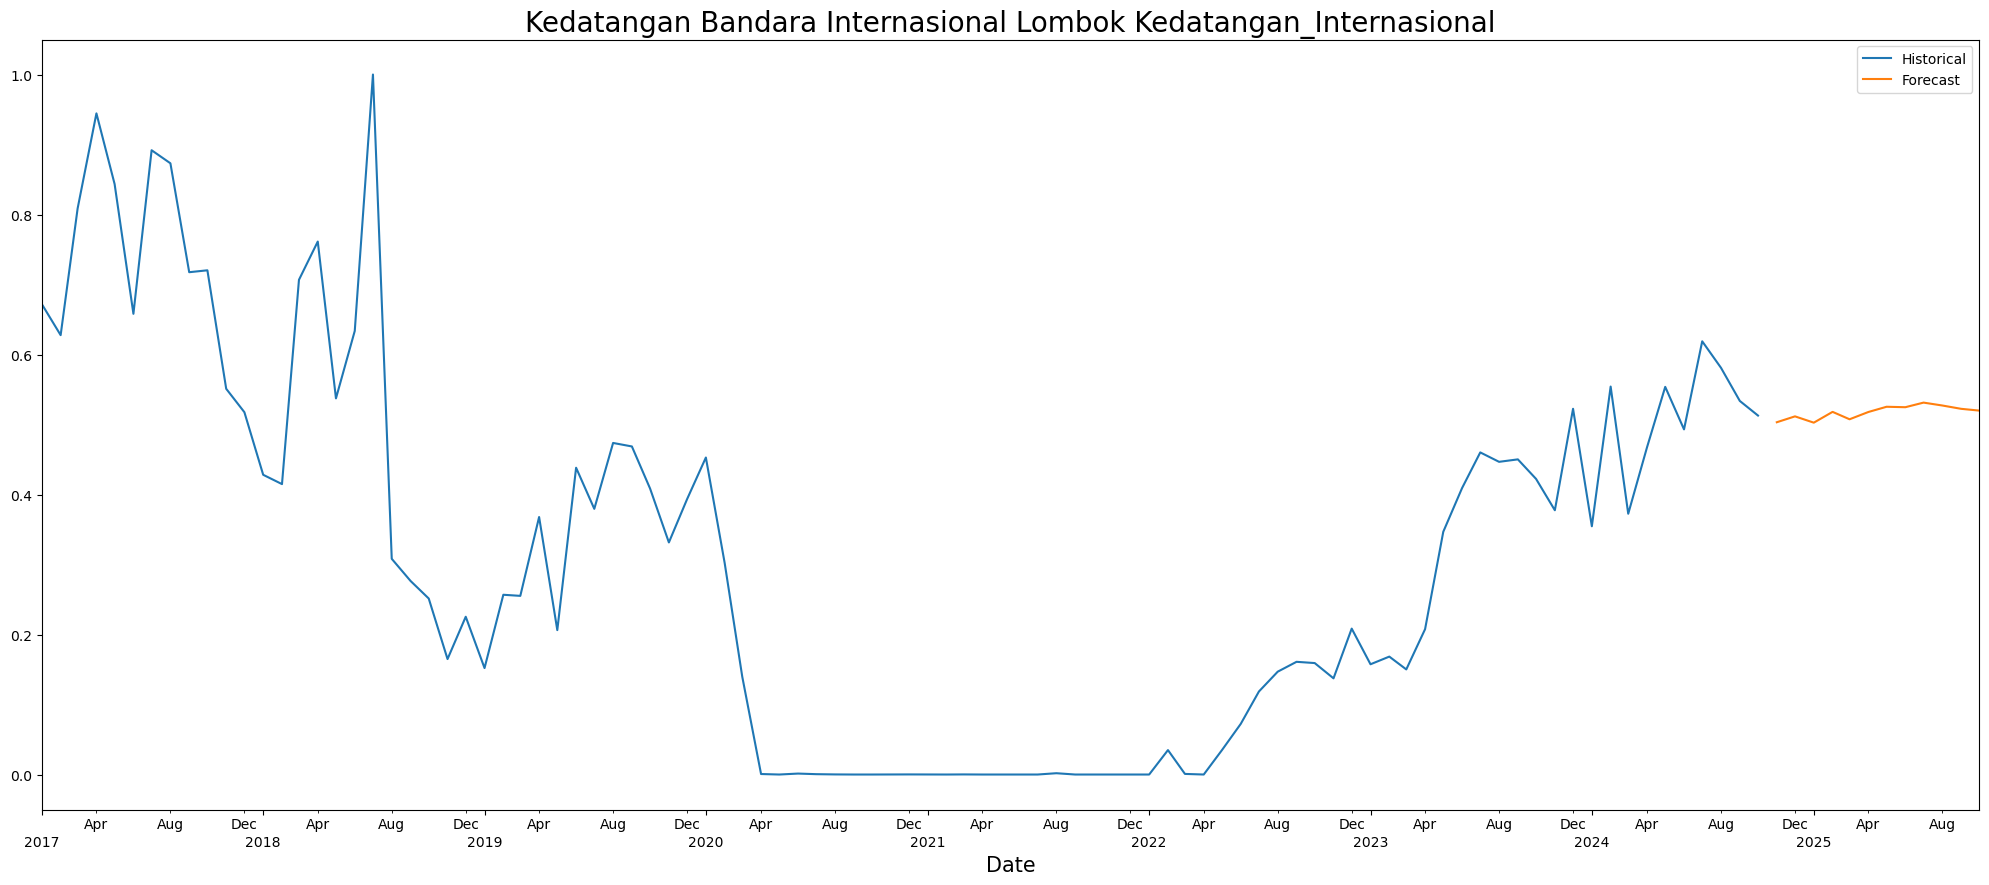

In [130]:
forecast = LSTM_forecast[ARRIVAL]
forecast = forecast.reset_index()
combined_data = combine_data(ARRIVAL, forecast, data)
visualize(combined_data, var=['Historical', 'Forecast',], label=ARRIVAL)

### Hybrid (SARIMA-LSTM)